In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import logging  
import time  
from datetime import datetime  

def setup_logger():  
    logger = logging.getLogger('RumorModel')  
    logger.setLevel(logging.INFO)  
    
    # 创建控制台处理器  
    console_handler = logging.StreamHandler()  
    console_handler.setLevel(logging.INFO)  
    
    # 创建格式器  
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')  
    console_handler.setFormatter(formatter)  
    
    # 清除现有的处理器  
    if logger.handlers:  
        logger.handlers = []  
    
    # 添加处理器  
    logger.addHandler(console_handler)  
    
    return logger

In [2]:
# Part 2: 网络生成函数  
def generate_scalefree_network(N, m, logger):  
    logger.info(f"开始生成无标度网络 (N={N}, m={m})")  
    start_time = time.time()  
    
    A = np.zeros((N, N), dtype=int)  
    
    # 初始完全图  
    for i in range(m + 1):  
        for j in range(i + 1, m + 1):  
            A[i, j] = A[j, i] = 1  
    
    # 添加剩余节点  
    for i in range(m + 1, N):  
        if i % 500 == 0:  
            logger.info(f"网络生成进度: {i}/{N} 节点 ({(i/N*100):.1f}%)")  
        
        degrees = np.sum(A, axis=0)  
        probs = degrees / np.sum(degrees)  
        
        connected = 0  
        while connected < m:  
            potential_nodes = np.arange(i)  
            chosen_node = np.random.choice(potential_nodes, p=probs[:i])  
            if A[i, chosen_node] == 0:  
                A[i, chosen_node] = A[chosen_node, i] = 1  
                connected += 1  
    
    elapsed_time = time.time() - start_time  
    logger.info(f"无标度网络生成完成，耗时: {elapsed_time:.2f}秒")  
    return A

In [3]:
# Part 3: 影响范围计算函数  
def get_influence_range(A, source, layers, logger):  
    N = A.shape[0]  
    is_influenced = np.zeros(N, dtype=bool)  
    is_influenced[source] = True  
    current_layer = [source]  
    
    logger.debug(f"计算节点 {source} 的影响范围 (层数={layers})")  
    
    for layer in range(layers):  
        next_layer_mask = np.zeros(N, dtype=bool)  
        for node in current_layer:  
            next_layer_mask |= (A[node] > 0)  
        
        next_layer_mask &= ~is_influenced  
        is_influenced |= next_layer_mask  
        current_layer = np.where(next_layer_mask)[0]  
        
        logger.debug(f"第 {layer+1} 层影响节点数: {len(current_layer)}")  
    
    return np.where(is_influenced)[0]

In [5]:
# Part 4: 主模型函数  
def rumor_spreading_model(N, m, I0, T, Td, D0, official_ratio, official_layers, opinion_layers,   
                         alpha_i, alpha_r, alpha_d, beta_d, delta):  
    # 设置日志  
    logger = setup_logger()  
    logger.info("开始运行谣言传播模型")  
    logger.info(f"参数设置: N={N}, I0={I0}, T={T}, Td={Td}, D0={D0}, official_ratio={official_ratio}")  
    
    # 生成网络  
    A = generate_scalefree_network(N, m, logger)  
    
    # 初始化状态  
    logger.info("初始化节点状态")  
    states = np.ones(N, dtype=int)  
    initial_spreaders = np.random.choice(N, I0, replace=False)  
    states[initial_spreaders] = 2  
    
    debunker_types = np.zeros(N, dtype=int)  
    
    # 初始化状态记录数组  
    St = np.zeros(T + 1)  
    It = np.zeros(T + 1)  
    Dt = np.zeros(T + 1)  
    Rt = np.zeros(T + 1)  
    
    # 记录初始状态  
    St[0] = np.sum(states == 1) / N  
    It[0] = np.sum(states == 2) / N  
    Dt[0] = np.sum(states == 3) / N  
    Rt[0] = np.sum(states == 4) / N  
    
    logger.info(f"初始状态: S={St[0]:.3f}, I={It[0]:.3f}, D={Dt[0]:.3f}, R={Rt[0]:.3f}")  
    
    D0_official = round(D0 * official_ratio)  
    D0_opinion = D0 - D0_official  
    
    # 主循环  
    simulation_start_time = time.time()  
    for t in range(1, T + 1):  
        iteration_start_time = time.time()  
        logger.info(f"\n时间步 {t}/{T} 开始")  
        
        # 在Td时刻加入辟谣者  
        if t == Td:  
            logger.info("辟谣者进入系统")  
            degrees = np.sum(A, axis=1)  
            sorted_indices = np.argsort(-degrees)  
            available_nodes = sorted_indices[states[sorted_indices] == 1]  
            
            official_debunkers = available_nodes[:min(D0_official, len(available_nodes))]  
            states[official_debunkers] = 3  
            debunker_types[official_debunkers] = 1  
            
            remaining_nodes = available_nodes[D0_official:]  
            opinion_debunkers = remaining_nodes[:min(D0_opinion, len(remaining_nodes))]  
            states[opinion_debunkers] = 3  
            debunker_types[opinion_debunkers] = 2  
            
            logger.info(f"添加了 {len(official_debunkers)} 个官方媒体和 {len(opinion_debunkers)} 个意见领袖")  
        
        new_states = np.copy(states)  
        
        # 状态更新  
        for i in range(N):  
            if i % 1000 == 0:  
                logger.debug(f"处理节点 {i}/{N}")  
            
            neighbors = np.where(A[i])[0]  
            
            # 针对不同状态的节点进行更新  
            if t < Td:  # Td之前的状态转换  
                if states[i] == 1:  # S状态  
                    for j in neighbors:  
                        if states[j] == 2:  
                            r = np.random.rand()  
                            if r <= alpha_r:  
                                new_states[i] = 4  
                                break  
                            elif r <= alpha_r + alpha_i:  
                                new_states[i] = 2  
                                break  
                elif states[i] == 2:  # I状态  
                    for j in neighbors:  
                        if states[j] in [2, 4]:  
                            if np.random.rand() <= delta:  
                                new_states[i] = 4  
                                break  
            
            else:  # Td之后的状态转换  
                if states[i] == 1:  # S状态  
                    under_official = False  
                    under_opinion = False  
                    
                    # 检查是否在官方媒体影响范围内  
                    for od in np.where(debunker_types == 1)[0]:  
                        if i in get_influence_range(A, od, official_layers, logger):  
                            under_official = True  
                            break  
                    
                    # 检查是否在意见领袖影响范围内  
                    if not under_official:  
                        for ol in np.where(debunker_types == 2)[0]:  
                            if i in get_influence_range(A, ol, opinion_layers, logger):  
                                under_opinion = True  
                                break  
                    
                    # 调整转换概率  
                    local_alpha_r = alpha_r  
                    local_alpha_d = alpha_d  
                    if under_official:  
                        local_alpha_r *= 1.5  
                        local_alpha_d *= 1.3  
                    elif under_opinion:  
                        local_alpha_r *= 1.3  
                        local_alpha_d *= 1.2  
                    
                    for j in neighbors:  
                        if states[j] in [2, 3]:  
                            r = np.random.rand()  
                            if r <= local_alpha_r:  
                                new_states[i] = 4  
                                break  
                            elif r <= local_alpha_r + alpha_i:  
                                new_states[i] = 2  
                                break  
                            elif r <= local_alpha_r + alpha_i + local_alpha_d:  
                                new_states[i] = 3  
                                debunker_types[i] = 3  
                                break  
                
                elif states[i] == 2:  # I状态  
                    under_official = False  
                    under_opinion = False  
                    
                    for od in np.where(debunker_types == 1)[0]:  
                        if i in get_influence_range(A, od, official_layers, logger):  
                            under_official = True  
                            break  
                    
                    if not under_official:  
                        for ol in np.where(debunker_types == 2)[0]:  
                            if i in get_influence_range(A, ol, opinion_layers, logger):  
                                under_opinion = True  
                                break  
                    
                    local_beta_d = beta_d  
                    local_delta = delta  
                    if under_official:  
                        local_beta_d *= 1.5  
                        local_delta *= 1.3  
                    elif under_opinion:  
                        local_beta_d *= 1.3  
                        local_delta *= 1.2  
                    
                    for j in neighbors:  
                        if states[j] == 3:  
                            if np.random.rand() <= local_beta_d:  
                                new_states[i] = 3  
                                debunker_types[i] = 3  
                                break  
                        elif states[j] in [2, 3, 4]:  
                            if np.random.rand() <= local_delta:  
                                new_states[i] = 4  
                                break  
                
                elif states[i] == 3:  # D状态  
                    if debunker_types[i] > 0:  
                        for j in neighbors:  
                            if states[j] in [2, 3, 4]:  
                                if debunker_types[i] == 3:  
                                    if np.random.rand() <= delta:  
                                        new_states[i] = 4  
                                        break  
                                else:  
                                    if np.random.rand() <= delta * 0.3:  
                                        new_states[i] = 4  
                                        break  
        
        states = new_states  
        
        # 记录状态比例  
        St[t] = np.sum(states == 1) / N  
        It[t] = np.sum(states == 2) / N  
        Dt[t] = np.sum(states == 3) / N  
        Rt[t] = np.sum(states == 4) / N  
        
        iteration_time = time.time() - iteration_start_time  
        logger.info(f"时间步 {t} 完成，耗时: {iteration_time:.2f}秒")  
        logger.info(f"当前状态: S={St[t]:.3f}, I={It[t]:.3f}, D={Dt[t]:.3f}, R={Rt[t]:.3f}")  
    
    total_time = time.time() - simulation_start_time  
    logger.info(f"\n模拟完成，总耗时: {total_time:.2f}秒")  
    
    return St, It, Dt, Rt

In [6]:
# Part 5: 绘图函数  
def plot_results(St, It, Dt, Rt, T, Td, official_ratio):  
    plt.figure(figsize=(10, 6))  
    plt.plot(range(T + 1), St, '-*', linewidth=1.5, label='易感者(S)')  
    plt.plot(range(T + 1), It, '-d', linewidth=1.5, label='谣言传播者(I)')  
    plt.plot(range(T + 1), Dt, '-^', linewidth=1.5,   
            label=f'辟谣者(D)\n其中官方媒体{100*official_ratio:.1f}%\n意见领袖{100*(1-official_ratio):.1f}%')  
    plt.plot(range(T + 1), Rt, '-p', linewidth=1.5, label='已恢复者(R)')  
    plt.axvline(x=Td, color='r', linestyle='--', label='辟谣者进入时间')  
    plt.xlabel('时间')  
    plt.ylabel('比例')  
    plt.title('两阶段谣言传播模型')  
    plt.legend(loc='best')  
    plt.grid(True)  
    plt.tight_layout()  
    
    # 保存图表  
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')  
    plt.savefig(f'rumor_model_result_{timestamp}.png')  
    plt.show()

2024-11-18 01:59:46,873 - INFO - 开始运行谣言传播模型
2024-11-18 01:59:46,876 - INFO - 参数设置: N=5000, I0=10, T=50, Td=20, D0=50, official_ratio=0.3
2024-11-18 01:59:46,878 - INFO - 开始生成无标度网络 (N=5000, m=2)
2024-11-18 01:59:50,846 - INFO - 网络生成进度: 500/5000 节点 (10.0%)
2024-11-18 01:59:53,883 - INFO - 网络生成进度: 1000/5000 节点 (20.0%)
2024-11-18 01:59:57,008 - INFO - 网络生成进度: 1500/5000 节点 (30.0%)
2024-11-18 02:00:00,157 - INFO - 网络生成进度: 2000/5000 节点 (40.0%)
2024-11-18 02:00:03,464 - INFO - 网络生成进度: 2500/5000 节点 (50.0%)
2024-11-18 02:00:06,790 - INFO - 网络生成进度: 3000/5000 节点 (60.0%)
2024-11-18 02:00:10,231 - INFO - 网络生成进度: 3500/5000 节点 (70.0%)
2024-11-18 02:00:13,839 - INFO - 网络生成进度: 4000/5000 节点 (80.0%)
2024-11-18 02:00:17,696 - INFO - 网络生成进度: 4500/5000 节点 (90.0%)
2024-11-18 02:00:21,887 - INFO - 无标度网络生成完成，耗时: 35.01秒
2024-11-18 02:00:21,890 - INFO - 初始化节点状态
2024-11-18 02:00:21,892 - INFO - 初始状态: S=0.998, I=0.002, D=0.000, R=0.000
2024-11-18 02:00:21,893 - INFO - 
时间步 1/50 开始
2024-11-18 02:00:21,957 - INFO - 时

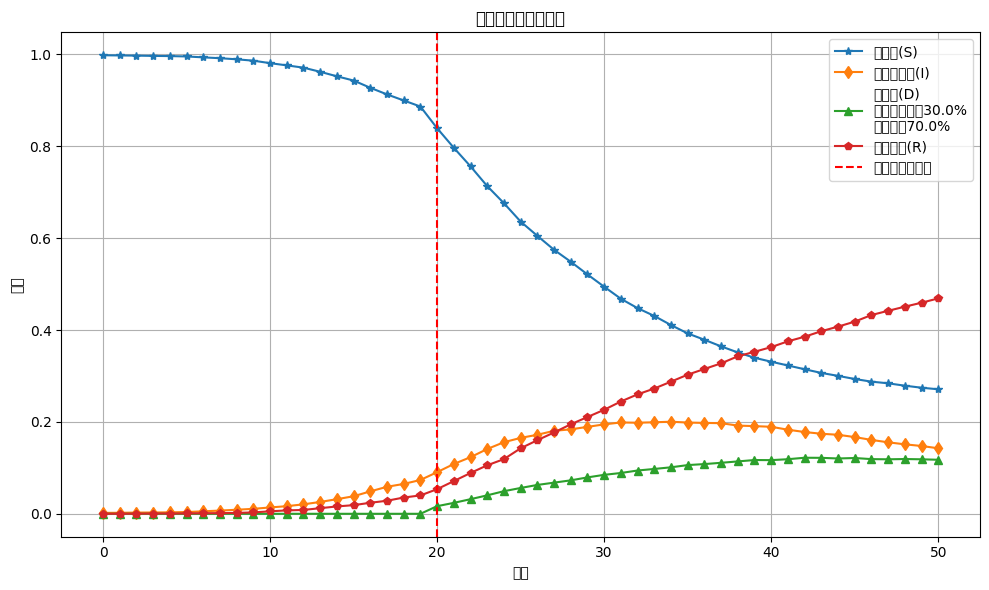

In [7]:
# Part 6: 运行示例  
# 设置参数  
N = 5000  # 网络规模  
m = 2     # 每个新节点连接的边数  
I0 = 10   # 初始谣言传播者数量  
T = 50    # 总时间步数  
Td = 10   # 辟谣者进入时间  
D0 = 10   # 初始辟谣者数量  
official_ratio = 0.1  # 官方媒体比例  
official_layers = 3   # 官方媒体影响层数  
opinion_layers = 2    # 意见领袖影响层数  
alpha_i = 0.1  # S转化为I的概率  0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4
alpha_r = 0.8  # S转化为R的概率  
alpha_d = 0.1  # S转化为D的概率  
beta_d = 0.6   # I转化为D的概率  
delta = 0.5    # I或D转化为R的概率  

# 运行模型  
St, It, Dt, Rt = rumor_spreading_model(N, m, I0, T, Td, D0, official_ratio,   
                                     official_layers, opinion_layers,   
                                     alpha_i, alpha_r, alpha_d, beta_d, delta)  

# 绘制结果  
plot_results(St, It, Dt, Rt, T, Td, official_ratio)